# Setup

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print(project_root)

/data/data3/junibg-ego/Modelo_leo_coi


In [2]:
import torch
print(f"¿GPU disponible? {torch.cuda.is_available()}")
print(f"Número de GPUs: {torch.cuda.device_count()}")
print(f"Nombre GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")


¿GPU disponible? True
Número de GPUs: 2
Nombre GPU: NVIDIA GeForce RTX 3090


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import json

# Tus imports
from src.combined_model.combined_model_embedding import *
from src.combined_model.combined_models import *
from src.decoders.decoder_simple import *
from src.encoders_model.DNABERT_Embedder import *
from src.encoders_model.embdeeding_encoders import *
from src.encoders_model.simple_encoders import *
from src.evaluators.linear_evaluator import *
from src.decoders.sequence_decoder import *
import numpy as np


In [4]:
from src.encoders_model.simple_encoders import *
from src.utils.load_fastaDataset import *
from src.training.experimentRunner import *
from torch.utils.data import DataLoader

In [5]:
def load_hierarchy_from_json(json_path):
    """Carga la jerarquía taxonómica desde JSON"""
    with open(json_path, 'r') as f:
        hierarchy_raw = json.load(f)
    
    # Convertir claves string a int
    hierarchy = {}
    for child_taxon, parent_dict in hierarchy_raw.items():
        hierarchy[child_taxon] = {}
        for parent_key, children_list in parent_dict.items():
            parent_int = int(float(parent_key))
            children_int = [int(c) for c in children_list]
            hierarchy[child_taxon][parent_int] = children_int
    
    print("✅ Jerarquía cargada desde JSON")
    for taxon, mapping in hierarchy.items():
        n_parents = len(mapping)
        n_children = sum(len(v) for v in mapping.values())
        print(f"  {taxon:10s}: {n_parents:4d} padres → {n_children:5d} hijos")
    
    return hierarchy

In [6]:
hierarchy_path = os.path.join(project_root, "src", "data", "taxonomy_hierarchy_fixed_with_class.json")
hierarchy = load_hierarchy_from_json(hierarchy_path)

✅ Jerarquía cargada desde JSON
  class     :   49 padres →   187 hijos
  order     :  173 padres →   831 hijos
  family    :  797 padres →  5446 hijos
  genus     : 5393 padres → 50568 hijos
  species   : 50510 padres → 205075 hijos


In [7]:
df = os.path.join(project_root, "src", "data", "all_taxa_numeric.csv")
df = pd.read_csv(df)

In [8]:
taxon_order = ['phylum', 'class','order', 'family', 'genus', 'species']
total_classes = {}
for taxon in taxon_order:
    n_classes = df[taxon].nunique()
    total_classes[taxon] = n_classes
    print(f"  {taxon:10s}: {n_classes:6d} clases")

  phylum    :     49 clases
  class     :    173 clases
  order     :    797 clases
  family    :   5393 clases
  genus     :  50510 clases
  species   : 205075 clases


# Definimos Variables

In [9]:
max_length = 750
batch_size = 8

# Cargamos el Modelo

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Dispositivo: {device}")

# DNABERT
dnabert_path = os.path.join(project_root, "src", "data", "archives")
dnabert = DNABERTEmbedder(
    model_name=dnabert_path,
    max_length=max_length,
    device=device
)
embed_dim = dnabert.get_embedding_dim()

# Encoder
latent_dim = 256
encoder = SimpleEmbeddingEncoder(
    embed_dim=embed_dim,
    latent_dim=latent_dim,
    dropout=0.1
)

# Decoders (uno por taxón)
decoders_dict = {}
for taxon in taxon_order:
    decoders_dict[taxon] = SequenceDecoder(
        latent_dim=latent_dim,
        seq_len=max_length,
        vocab_size=4,
        dropout=0.1
    )

# Global decoder
global_decoder = SequenceDecoder(
    latent_dim=latent_dim,
    seq_len=max_length,
    vocab_size=4,
    dropout=0.1
)

# Classifiers (uno por taxón)
classifiers_dict = {}
print(f"\n🔧 Creando classifiers con número TOTAL de clases:")
for taxon in taxon_order:
    # ✅ CORRECTO: Usar total_classes (del dataset completo)
    # ❌ INCORRECTO: n_classes = df_train[taxon].nunique()
    n_classes = total_classes[taxon]
    
    classifiers_dict[taxon] = CosineClassifier(
        latent_dim=latent_dim,
        num_classes=n_classes,
        scale=20.0  # ⭐ Ajustable si es necesario
    )
    print(f"  {taxon:10s}: {n_classes:6d} clases")

# ⭐ CREAR MODELO JERÁRQUICO
model = HierarchicalCombinedModelFixed(
    dnabert=dnabert,
    encoder=encoder,
    decoders_dict=decoders_dict,
    classifiers_dict=classifiers_dict,
    global_decoder=global_decoder,
    taxonomy_hierarchy=hierarchy  # ⭐ Aquí usas la jerarquía
)

print(f"\n✅ Modelo jerárquico creado")

🖥️  Dispositivo: cuda


Some weights of BertModel were not initialized from the model checkpoint at /data/data3/junibg-ego/Modelo_leo_coi/src/data/archives and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔧 Creando classifiers con número TOTAL de clases:
  phylum    :     49 clases
  class     :    173 clases
  order     :    797 clases
  family    :   5393 clases
  genus     :  50510 clases
  species   : 205075 clases
✅ Modelo jerárquico creado con máscaras suaves (no -inf)

✅ Modelo jerárquico creado


In [11]:

checkpoint_path = os.path.join(project_root, "src", "data", "checkpointss", "final_model.pt")
checkpoint = torch.load(checkpoint_path, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval() 


HierarchicalCombinedModelFixed(
  (dnabert): DNABERTEmbedder(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(4096, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertUnpadAttention(
              (self): BertUnpadSelfAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (mlp): BertG

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


HierarchicalCombinedModelFixed(
  (dnabert): DNABERTEmbedder(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(4096, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertUnpadAttention(
              (self): BertUnpadSelfAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (mlp): BertG

# Cargamos el DataLoader

In [13]:
from sklearn.model_selection import train_test_split

# Primero separar test (20%)
df_temp, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['phylum']
)

# Luego separar train/val (80/20 del 80% restante = 64/16 del total)
df_train, df_val = train_test_split(
    df_temp, test_size=0.2, random_state=42, stratify=df_temp['phylum']
)

In [14]:
val_dataset = MultiTaxaFastaDataset(
    df_val.reset_index(drop=True),
    max_length=max_length,
    taxon_cols=taxon_order
)

test_dataset = MultiTaxaFastaDataset(
    df_test.reset_index(drop=True),
    max_length=max_length,
    taxon_cols=taxon_order
)

In [15]:
def collate_multitask(batch, taxon_cols=['phylum', 'class','order','family','genus','species'], max_length=900):
    sequences, labels_dict_list, recon_targets_list, true_tokens_list = zip(*batch)

    # Labels: dict de tensors
    labels_dict = {taxon: torch.stack([d[taxon] for d in labels_dict_list]) for taxon in taxon_cols}

    # Recon targets: dict de tensors
    recon_targets_dict = {taxon: torch.stack([d[taxon] for d in recon_targets_list]) for taxon in taxon_cols}

    # True tokens
    true_tokens = torch.stack(true_tokens_list)

    return sequences, labels_dict

In [16]:
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda b: collate_multitask(b, taxon_cols=val_dataset.taxon_cols, max_length=val_dataset.max_length),
    num_workers=6
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda b: collate_multitask(b, taxon_cols=val_dataset.taxon_cols, max_length=val_dataset.max_length),
    num_workers=6
)

# Algoritmo Genetico

In [17]:
def classify(sequences):
    probs_by_rank = []
    
    with torch.no_grad():
        predictions = model(sequences)['logits']    
        # predictions is a list of [rank0_output, rank1_output, rank2_output, ...]
        # Each rank_output has shape [batch_size, num_classes_for_that_rank]
            
        for rank, rank_pred in predictions.items():
            # Get probabilities for all sequences in this rank
            probs = torch.softmax(rank_pred, dim=-1).cpu().numpy()
            probs_by_rank.append(probs)
        
        return probs_by_rank

In [18]:
from src.genetics.genetic_algorithm_dna import GeneticAlgorithmDNA
from src.genetics.dna_sequence_perturber import DNASequencePerturber

In [19]:


os.environ["TOKENIZERS_PARALLELISM"] = "false"

populations = []

print("\n" + "="*60)
print("STARTING GENETIC ALGORITHM EXPERIMENTS")
print("="*60)

# Create GA
ga = GeneticAlgorithmDNA(
    classify,
    [0],
    population_size = 100,
    
    max_n_count = 400,
    max_sequence_lengths = max_length,

    entropy_weight=200,
    n_penalty_weight = 0.5,
    discontinuity_penalty_weight = 50,
    
    mutation_rate = 0.5,
    crossover_rate = 0.7,
    tournament_size = 4,
    elitism_count = 3
)

for i in range(1):
    # Run GA
    best_solution, history, last_population = ga.run(
        val_loader, 
        epochs = 10
    )

    populations.append(last_population)



STARTING GENETIC ALGORITHM EXPERIMENTS


Evolution:   1%|▎                                                      | 176/30890 [06:19<18:24:38,  2.16s/it, fitness=4766.0737, entropy=23.8371, n_count=81, patience=1]



Epoch [1/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2409.1543
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                        | 49/30890 [01:10<12:19:24,  1.44s/it, fitness=4766.0737, entropy=23.8371, n_count=81, patience=1]



Epoch [2/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2507.4988
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                        | 24/30890 [00:33<12:05:15,  1.41s/it, fitness=4766.0737, entropy=23.8371, n_count=81, patience=1]



Epoch [3/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2389.8394
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                        | 11/30890 [00:15<11:52:25,  1.38s/it, fitness=4766.0737, entropy=23.8371, n_count=81, patience=1]



Epoch [4/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2469.0266
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                         | 5/30890 [00:08<14:20:39,  1.67s/it, fitness=4766.0737, entropy=23.8371, n_count=81, patience=1]



Epoch [5/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2500.9438
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                         | 2/30890 [00:05<22:13:00,  2.59s/it, fitness=4766.0737, entropy=23.8371, n_count=81, patience=1]



Epoch [6/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2343.2615
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                                                                                                | 0/30890 [00:02<?, ?it/s]



Epoch [7/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2660.5232
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                                                                                                | 0/30890 [00:01<?, ?it/s]



Epoch [8/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2314.7876
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                                                                                                | 0/30890 [00:02<?, ?it/s]



Epoch [9/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2318.4053
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


Evolution:   0%|                                                                                                                                | 0/30890 [00:02<?, ?it/s]


Epoch [10/10]

Genetic Algorithm Status
  Best Fitness:              4766.0737
  Average Fitness:           2452.3447
  Best Entropy Score:        23.8371
  Best N Count:              81
  Best N Count Penalty:      0.1013
  Best Continuity Penalty:   1.2500

{'sequence_length': 750, 'n_positions': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546], 'fitness': np.float32(4766.0737), 'entropy_score': np.float32(23.837124), 'n_count_penalty': 0.10125, 'continuity_penalty': 1.250000000000001}


In [ ]:
from scipy.ndimage import gaussian_filter1d
from datetime import datetime

def plot_population_n_heatmap(population, smooth_sigma=3):
    """
    Given a population of individuals, each with n_positions,
    plot a smoothed 1D heatmap showing the normalized frequency 
    of 'N' at each sequence position.

    Parameters
    ----------
    population : list of dicts
        Each dict must contain:
        - 'sequence_length'
        - 'n_positions' : list of indices where the individual places Ns
    smooth_sigma : float
        Gaussian smoothing strength for the 1D signal.
    """

    # Assume all individuals have same sequence length
    seq_len = population[0].sequence_length
    pop_size = len(population)

    # Count Ns per position
    freq = np.zeros(seq_len)

    for indiv in population:
        freq[indiv.n_positions] += 1

    # Normalize to [0,1]
    freq /= pop_size

    # Smooth the curve
    smooth_freq = gaussian_filter1d(freq, sigma=smooth_sigma)

    # Plot heatmap-like bar
    plt.figure(figsize=(14, 3))

    plt.imshow(
        smooth_freq[np.newaxis, :], 
        cmap='magma',
        aspect='auto',
        interpolation='nearest'
    )

    plt.yticks([])  # 1D heatmap → no y-axis needed
    plt.xlabel("Sequence Position")
    plt.title("Smoothed N-Frequency Heatmap (Population-Level)")

    plt.colorbar(label="Normalized Frequency")
    plt.tight_layout()

    date = datetime.now().strftime("%Y%m%d")
    plt.savefig(f"population_n_heatmap_{date}.png", dpi=300, bbox_inches='tight')

    plt.show()

    return freq, smooth_freq

In [ ]:
for population in populations: 
    plot_population_n_heatmap(population)

flattened_pop = []
for population in populations:
    flattened_pop.extend(population)

freq, smooth_freq = plot_population_n_heatmap(flattened_pop)


20.0


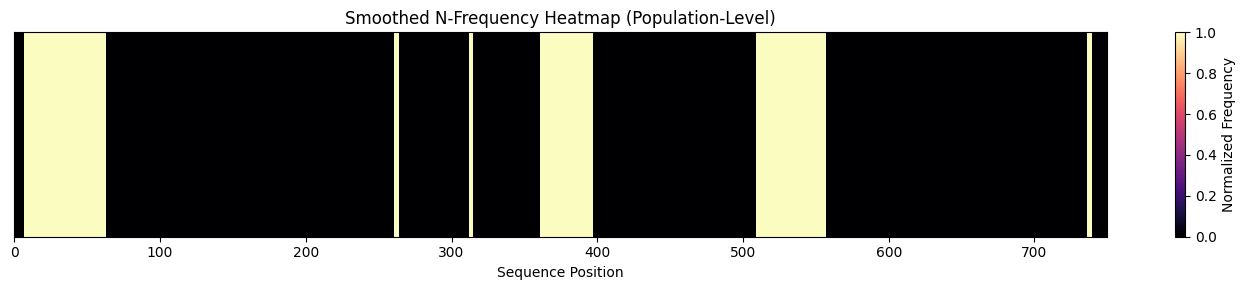

In [22]:
p80 = np.percentile(smooth_freq, 80)

a = (smooth_freq > p80)
print((np.sum(a) / 750)*100)

plt.figure(figsize=(14, 3))

plt.imshow(
    a[np.newaxis, :], 
    cmap='magma',
    aspect='auto',
    interpolation='nearest'
)

plt.yticks([])  # 1D heatmap → no y-axis needed
plt.xlabel("Sequence Position")
plt.title("Smoothed N-Frequency Heatmap (Population-Level)")

plt.colorbar(label="Normalized Frequency")
plt.tight_layout()

plt.show()


In [23]:
p90 = np.percentile(smooth_freq, 80)
important_zones = (smooth_freq > p90)
n_positions = np.nonzero(important_zones)[0]
best_perturber = DNASequencePerturber(len(smooth_freq), n_positions)

In [24]:
total_acc = 0
total = 0
pbar = tqdm(test_loader, desc="Evolution")
for sequences, labels in pbar:

    total += batch_size 
    
    phylo_label = labels["phylum"]
    
    perturbed_batch = [best_perturber.apply_to_sequence(seq) for seq in sequences]
    predicciones = classify(perturbed_batch)
    phylo_probs = torch.tensor(predicciones[0])
    phylo_predicctions = torch.argmax(phylo_probs, dim=1)
    acc = (phylo_predicctions == phylo_label).sum().item() 
    total_acc += acc

    pbar.set_postfix({
                    'accuracy': f'{(total_acc/total)*100:.4f}',
                })

print(total_acc / (len(test_loader) * batch_size))

Evolution:   2%|██                                                                                                | 801/38613 [02:07<1:39:56,  6.31it/s, accuracy=69.0075]


KeyboardInterrupt: 